In [14]:
# Basic libraries
import torch
import torch.nn as n
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from typing import List
import torch.optim as optim
from tqdm import tqdm
from omegaconf import OmegaConf

In [15]:
os.chdir("../")
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embeddings import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder, VanillaDecoder
from osgen.base import BaseModel
from osgen.nn import *
from osgen.unet import *
from osgen.loss import *
from osgen.pipeline import *

In [16]:
# Load config
cfg = OmegaConf.load("/root/BiOSGen/configs/train_config.yml")
print(cfg.verbose)

True


In [17]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


In [18]:
idx_src = 20 # torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src]))),
)

idx_dst = 60 # torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[idx_dst]))),
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

idx_src:  20
idx_dst:  60


In [19]:
# Initialize your pipeline
pipeline = OSGenPipeline()

# Load the checkpoint file (a state_dict)
checkpoints = torch.load("/root/BiOSGen/checkpoints/main/pipeline_full_best_100_epoch_512.pth")


/tmp/ipykernel_13498/3007567791.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load("/root/BiOSGen/checkpoints/main/pipeline_full_best_100_epoch_512

In [20]:
checkpoint_keys = set(checkpoints['model_state_dict'].keys())
pipeline_keys = set(pipeline.state_dict().keys())

print("Keys only in checkpoint:", checkpoint_keys - pipeline_keys)
print("Keys only in pipeline:", pipeline_keys - checkpoint_keys)
print("Common keys:", checkpoint_keys & pipeline_keys)

# Check for shape mismatches in common keys
print("\nShape mismatches:")
for key in checkpoint_keys & pipeline_keys:
    if checkpoints['model_state_dict'][key].shape != pipeline.state_dict()[key].shape:
        print(f"{key}: checkpoint shape = {checkpoints['model_state_dict'][key].shape}, pipeline shape = {pipeline.state_dict()[key].shape}")

Keys only in checkpoint: {'unet.output_blocks.0.0.post_adain.channel_reducer.weight', 'unet.output_blocks.4.0.pre_adain.channel_reducer.bias', 'unet.output_blocks.8.0.pre_adain.channel_reducer.weight', 'encoder.final_layer.1.running_mean', 'decoder.final_layer.1.num_batches_tracked', 'unet.output_blocks.1.0.post_adain.channel_reducer.bias', 'decoder.encoder.0.1.num_batches_tracked', 'unet.output_blocks.10.0.pre_adain.channel_reducer.bias', 'unet.output_blocks.8.0.pre_adain.channel_reducer.bias', 'unet.output_blocks.7.0.post_adain.channel_reducer.weight', 'unet.input_blocks.11.0.post_adain.channel_reducer.weight', 'encoder.decoder.0.1.num_batches_tracked', 'unet.middle_block.2.pre_adain.channel_reducer.weight', 'style_extractor.conv_style.1.running_mean', 'unet.output_blocks.2.0.pre_adain.channel_reducer.bias', 'unet.input_blocks.11.0.pre_adain.channel_reducer.bias', 'unet.input_blocks.5.0.pre_adain.channel_reducer.bias', 'style_extractor.conv_style.4.running_var', 'style_extractor.conv

In [21]:
# Hyperparameters
verbose = cfg.verbose
num_epochs = 100
batch_size = cfg.batch_size
lr = cfg.lr
optimizer = optim.AdamW([p for p in pipeline.parameters() if p.requires_grad], 
                        lr=cfg.optimizer.params.lr, weight_decay=cfg.optimizer.params.weight_decay, eps=cfg.optimizer.params.eps)

channels = cfg.channels
height = cfg.height
width = cfg.width
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lambda_content = cfg.lambda_content
lambda_style = cfg.lambda_style

# Training loop
# Put on training mode
pipeline.train()
requires_grad = True

# Early stopping parameters
early_stopping_patience = cfg.early_stopping_patience
epochs_without_improvement = 0
best_loss = float("inf")

# Convergence check parameters
convergence_patience = 5  # Number of epochs to check for convergence
convergence_threshold = 0.001  # Minimum relative change in loss to continue training
loss_history = []  # Keep track of recent losses

# Save losses
losses = []
content_losses = []
style_losses = []

# Switch to main training with bfloat16
for epoch in tqdm(range(num_epochs)):
    # print(f"Epoch {epoch+1}/{num_epochs}")
    avg_loss = []
    content_loss = []
    style_loss = []

    for i, (src, dst) in enumerate(zip(patches_src, patches_dst)):
        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        decoded = pipeline(src_tensor, dst_tensor, timesteps)

        # Handle gradients issues
        requires_grad = decoded.requires_grad
        # print(requires_grad)
        if not requires_grad:
            break

        # Compute loss
        content_l, style_l, total_loss = pipeline.compute_loss(src_tensor, dst_tensor, decoded, lambda_content, lambda_style)

        # Break if total_loss is NaN
        if torch.isnan(total_loss):
            print(f"NaN loss at epoch {epoch+1}, batch {i+1}")
            break

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(patches_src)}, "
                f"Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}, "
                f"Total Loss: {total_loss.item():.4f}")

        avg_loss.append(total_loss.item())
        content_loss.append(content_l.item())
        style_loss.append(style_l.item())

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    
    current_loss = np.mean(avg_loss)
    losses.append(current_loss)
    content_losses.append(np.mean(content_loss))
    style_losses.append(np.mean(style_loss))

    # Early stopping (original implementation)
    if current_loss < best_loss:
        best_loss = current_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if verbose: 
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(patches_src)}, "
                f"Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}, "
                f"Total Loss: {total_loss.item():.4f}")
            
            # Save the checkpoints
            torch.save(pipeline.state_dict(), f"/root/BiOSGen/checkpoints/pipeline_epoch_{epoch+1}.pth")
            print(f"Model saved at /root/BiOSGen/checkpoints/pipeline_epoch_{epoch+1}.pth")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Batch 1/95, Content Loss: 90.4591, Style Loss: 195.2612, Total Loss: 285.7204
Epoch 1/100, Batch 2/95, Content Loss: 151.7714, Style Loss: 854.4639, Total Loss: 1006.2354
Epoch 1/100, Batch 3/95, Content Loss: 147.1078, Style Loss: 811.0617, Total Loss: 958.1695
Epoch 1/100, Batch 4/95, Content Loss: 91.9412, Style Loss: 57.5412, Total Loss: 149.4824
Epoch 1/100, Batch 5/95, Content Loss: 134.0511, Style Loss: 31.0682, Total Loss: 165.1193
Epoch 1/100, Batch 6/95, Content Loss: 169.4799, Style Loss: 131.9494, Total Loss: 301.4294
Epoch 1/100, Batch 7/95, Content Loss: 210.0653, Style Loss: 63.7736, Total Loss: 273.8389
Epoch 1/100, Batch 8/95, Content Loss: 175.7264, Style Loss: 45.2279, Total Loss: 220.9543
Epoch 1/100, Batch 9/95, Content Loss: 166.6731, Style Loss: 30.8390, Total Loss: 197.5121
Epoch 1/100, Batch 10/95, Content Loss: 182.7088, Style Loss: 65.2152, Total Loss: 247.9240
Epoch 1/100, Batch 11/95, Content Loss: 170.2373, Style Loss: 50.4268, Total Loss: 220

  1%|          | 1/100 [00:16<26:37, 16.13s/it]

Model saved at /root/BiOSGen/checkpoints/pipeline_epoch_1.pth
Epoch 2/100, Batch 1/95, Content Loss: 36.7407, Style Loss: 17.0178, Total Loss: 53.7584
Epoch 2/100, Batch 2/95, Content Loss: 43.0777, Style Loss: 15.4608, Total Loss: 58.5384
Epoch 2/100, Batch 3/95, Content Loss: 30.5369, Style Loss: 22.4410, Total Loss: 52.9780
Epoch 2/100, Batch 4/95, Content Loss: 44.7430, Style Loss: 19.6469, Total Loss: 64.3899
Epoch 2/100, Batch 5/95, Content Loss: 37.4977, Style Loss: 16.9892, Total Loss: 54.4869
Epoch 2/100, Batch 6/95, Content Loss: 92.6078, Style Loss: 32.2433, Total Loss: 124.8511
Epoch 2/100, Batch 7/95, Content Loss: 96.4278, Style Loss: 13.7282, Total Loss: 110.1561
Epoch 2/100, Batch 8/95, Content Loss: 101.4958, Style Loss: 21.8589, Total Loss: 123.3547
Epoch 2/100, Batch 9/95, Content Loss: 99.8843, Style Loss: 18.5820, Total Loss: 118.4663
Epoch 2/100, Batch 10/95, Content Loss: 96.2788, Style Loss: 26.9381, Total Loss: 123.2170
Epoch 2/100, Batch 11/95, Content Loss: 6

  2%|▏         | 2/100 [00:31<25:48, 15.80s/it]

Epoch 2/100, Batch 94/95, Content Loss: 56.8349, Style Loss: 13.3984, Total Loss: 70.2333
Epoch 3/100, Batch 1/95, Content Loss: 26.4326, Style Loss: 14.3291, Total Loss: 40.7617
Epoch 3/100, Batch 2/95, Content Loss: 33.8167, Style Loss: 11.1394, Total Loss: 44.9561
Epoch 3/100, Batch 3/95, Content Loss: 22.7713, Style Loss: 15.7108, Total Loss: 38.4821
Epoch 3/100, Batch 4/95, Content Loss: 14.4338, Style Loss: 15.4320, Total Loss: 29.8658
Epoch 3/100, Batch 5/95, Content Loss: 23.8686, Style Loss: 16.0586, Total Loss: 39.9273
Epoch 3/100, Batch 6/95, Content Loss: 70.1663, Style Loss: 15.2916, Total Loss: 85.4579
Epoch 3/100, Batch 7/95, Content Loss: 85.2334, Style Loss: 19.5383, Total Loss: 104.7717
Epoch 3/100, Batch 8/95, Content Loss: 60.2109, Style Loss: 12.7731, Total Loss: 72.9839
Epoch 3/100, Batch 9/95, Content Loss: 62.4123, Style Loss: 8.6438, Total Loss: 71.0561
Epoch 3/100, Batch 10/95, Content Loss: 66.0645, Style Loss: 16.0327, Total Loss: 82.0972
Epoch 3/100, Batch 

  3%|▎         | 3/100 [00:46<25:07, 15.54s/it]

Epoch 3/100, Batch 94/95, Content Loss: 49.6886, Style Loss: 9.6706, Total Loss: 59.3591
Epoch 4/100, Batch 1/95, Content Loss: 39.6077, Style Loss: 9.5015, Total Loss: 49.1092
Epoch 4/100, Batch 2/95, Content Loss: 31.3403, Style Loss: 9.7161, Total Loss: 41.0565
Epoch 4/100, Batch 3/95, Content Loss: 27.4607, Style Loss: 12.2457, Total Loss: 39.7065
Epoch 4/100, Batch 4/95, Content Loss: 18.9773, Style Loss: 10.4801, Total Loss: 29.4574
Epoch 4/100, Batch 5/95, Content Loss: 26.3501, Style Loss: 9.8984, Total Loss: 36.2485
Epoch 4/100, Batch 6/95, Content Loss: 60.6649, Style Loss: 10.8373, Total Loss: 71.5021
Epoch 4/100, Batch 7/95, Content Loss: 75.9373, Style Loss: 9.9730, Total Loss: 85.9103
Epoch 4/100, Batch 8/95, Content Loss: 57.9493, Style Loss: 13.5087, Total Loss: 71.4581
Epoch 4/100, Batch 9/95, Content Loss: 64.2167, Style Loss: 7.4860, Total Loss: 71.7027
Epoch 4/100, Batch 10/95, Content Loss: 65.4199, Style Loss: 12.9359, Total Loss: 78.3558
Epoch 4/100, Batch 11/95,

  4%|▍         | 4/100 [01:02<24:53, 15.55s/it]

Epoch 4/100, Batch 94/95, Content Loss: 46.7479, Style Loss: 9.1094, Total Loss: 55.8573
Epoch 5/100, Batch 1/95, Content Loss: 35.2179, Style Loss: 9.1385, Total Loss: 44.3564
Epoch 5/100, Batch 2/95, Content Loss: 39.7003, Style Loss: 6.6544, Total Loss: 46.3547
Epoch 5/100, Batch 3/95, Content Loss: 30.0815, Style Loss: 8.6557, Total Loss: 38.7372
Epoch 5/100, Batch 4/95, Content Loss: 24.8892, Style Loss: 5.4799, Total Loss: 30.3691
Epoch 5/100, Batch 5/95, Content Loss: 25.2058, Style Loss: 10.2025, Total Loss: 35.4083
Epoch 5/100, Batch 6/95, Content Loss: 54.2636, Style Loss: 11.0109, Total Loss: 65.2745
Epoch 5/100, Batch 7/95, Content Loss: 70.4305, Style Loss: 8.0119, Total Loss: 78.4424
Epoch 5/100, Batch 8/95, Content Loss: 56.2046, Style Loss: 11.1401, Total Loss: 67.3447
Epoch 5/100, Batch 9/95, Content Loss: 64.4139, Style Loss: 6.7555, Total Loss: 71.1694
Epoch 5/100, Batch 10/95, Content Loss: 59.3030, Style Loss: 15.7301, Total Loss: 75.0330
Epoch 5/100, Batch 11/95, 

  5%|▌         | 5/100 [01:18<24:36, 15.54s/it]

Epoch 5/100, Batch 94/95, Content Loss: 40.3106, Style Loss: 7.1953, Total Loss: 47.5059
Epoch 6/100, Batch 1/95, Content Loss: 18.4310, Style Loss: 5.4810, Total Loss: 23.9120
Epoch 6/100, Batch 2/95, Content Loss: 32.1048, Style Loss: 4.2178, Total Loss: 36.3226
Epoch 6/100, Batch 3/95, Content Loss: 24.3963, Style Loss: 7.9449, Total Loss: 32.3412
Epoch 6/100, Batch 4/95, Content Loss: 14.3741, Style Loss: 5.9059, Total Loss: 20.2800
Epoch 6/100, Batch 5/95, Content Loss: 18.1587, Style Loss: 17.9309, Total Loss: 36.0896
Epoch 6/100, Batch 6/95, Content Loss: 43.6832, Style Loss: 9.7492, Total Loss: 53.4324
Epoch 6/100, Batch 7/95, Content Loss: 57.7153, Style Loss: 4.9252, Total Loss: 62.6404
Epoch 6/100, Batch 8/95, Content Loss: 46.2148, Style Loss: 9.9051, Total Loss: 56.1199
Epoch 6/100, Batch 9/95, Content Loss: 50.1910, Style Loss: 2.6942, Total Loss: 52.8852
Epoch 6/100, Batch 10/95, Content Loss: 52.4607, Style Loss: 17.6278, Total Loss: 70.0885
Epoch 6/100, Batch 11/95, Co

  6%|▌         | 6/100 [01:33<24:07, 15.40s/it]

Epoch 6/100, Batch 94/95, Content Loss: 35.0077, Style Loss: 8.4795, Total Loss: 43.4871
Epoch 7/100, Batch 1/95, Content Loss: 23.4308, Style Loss: 5.2588, Total Loss: 28.6896
Epoch 7/100, Batch 2/95, Content Loss: 30.3130, Style Loss: 5.0646, Total Loss: 35.3776
Epoch 7/100, Batch 3/95, Content Loss: 37.2768, Style Loss: 17.4052, Total Loss: 54.6820
Epoch 7/100, Batch 4/95, Content Loss: 17.0486, Style Loss: 11.4440, Total Loss: 28.4926
Epoch 7/100, Batch 5/95, Content Loss: 20.9067, Style Loss: 17.0006, Total Loss: 37.9073
Epoch 7/100, Batch 6/95, Content Loss: 49.6929, Style Loss: 9.0389, Total Loss: 58.7319
Epoch 7/100, Batch 7/95, Content Loss: 57.7971, Style Loss: 7.4383, Total Loss: 65.2353
Epoch 7/100, Batch 8/95, Content Loss: 50.6720, Style Loss: 20.5732, Total Loss: 71.2452
Epoch 7/100, Batch 9/95, Content Loss: 54.5404, Style Loss: 2.8200, Total Loss: 57.3604
Epoch 7/100, Batch 10/95, Content Loss: 63.3500, Style Loss: 15.3254, Total Loss: 78.6754
Epoch 7/100, Batch 11/95,

  7%|▋         | 7/100 [01:48<23:53, 15.42s/it]

Epoch 7/100, Batch 94/95, Content Loss: 31.1497, Style Loss: 8.8531, Total Loss: 40.0028
Epoch 8/100, Batch 1/95, Content Loss: 23.7183, Style Loss: 5.7377, Total Loss: 29.4561
Epoch 8/100, Batch 2/95, Content Loss: 30.3337, Style Loss: 4.6241, Total Loss: 34.9577
Epoch 8/100, Batch 3/95, Content Loss: 22.9176, Style Loss: 6.1811, Total Loss: 29.0987
Epoch 8/100, Batch 4/95, Content Loss: 12.5190, Style Loss: 6.4479, Total Loss: 18.9669
Epoch 8/100, Batch 5/95, Content Loss: 20.0619, Style Loss: 11.6991, Total Loss: 31.7610
Epoch 8/100, Batch 6/95, Content Loss: 36.0532, Style Loss: 8.8936, Total Loss: 44.9468
Epoch 8/100, Batch 7/95, Content Loss: 52.8301, Style Loss: 8.5682, Total Loss: 61.3983
Epoch 8/100, Batch 8/95, Content Loss: 43.1701, Style Loss: 16.2715, Total Loss: 59.4416
Epoch 8/100, Batch 9/95, Content Loss: 46.2960, Style Loss: 5.0666, Total Loss: 51.3626
Epoch 8/100, Batch 10/95, Content Loss: 51.1358, Style Loss: 24.1183, Total Loss: 75.2542
Epoch 8/100, Batch 11/95, C

  8%|▊         | 8/100 [02:03<23:19, 15.21s/it]

Epoch 8/100, Batch 94/95, Content Loss: 29.0253, Style Loss: 8.1349, Total Loss: 37.1603
Epoch 9/100, Batch 1/95, Content Loss: 21.5530, Style Loss: 3.9615, Total Loss: 25.5145
Epoch 9/100, Batch 2/95, Content Loss: 29.7904, Style Loss: 4.0523, Total Loss: 33.8427
Epoch 9/100, Batch 3/95, Content Loss: 18.2731, Style Loss: 5.5231, Total Loss: 23.7962
Epoch 9/100, Batch 4/95, Content Loss: 20.2506, Style Loss: 4.6122, Total Loss: 24.8628
Epoch 9/100, Batch 5/95, Content Loss: 17.4270, Style Loss: 14.8676, Total Loss: 32.2946
Epoch 9/100, Batch 6/95, Content Loss: 35.9193, Style Loss: 8.8854, Total Loss: 44.8047
Epoch 9/100, Batch 7/95, Content Loss: 50.7070, Style Loss: 7.1816, Total Loss: 57.8886
Epoch 9/100, Batch 8/95, Content Loss: 40.7413, Style Loss: 15.0418, Total Loss: 55.7832
Epoch 9/100, Batch 9/95, Content Loss: 43.4309, Style Loss: 3.6835, Total Loss: 47.1144
Epoch 9/100, Batch 10/95, Content Loss: 49.0227, Style Loss: 13.1610, Total Loss: 62.1837
Epoch 9/100, Batch 11/95, C

  9%|▉         | 9/100 [02:18<23:05, 15.23s/it]

Epoch 9/100, Batch 94/95, Content Loss: 27.6499, Style Loss: 7.4746, Total Loss: 35.1246
Epoch 10/100, Batch 1/95, Content Loss: 17.8688, Style Loss: 3.9901, Total Loss: 21.8589
Epoch 10/100, Batch 2/95, Content Loss: 25.6654, Style Loss: 4.0464, Total Loss: 29.7118
Epoch 10/100, Batch 3/95, Content Loss: 16.8870, Style Loss: 5.4137, Total Loss: 22.3007
Epoch 10/100, Batch 4/95, Content Loss: 10.3233, Style Loss: 6.4601, Total Loss: 16.7834
Epoch 10/100, Batch 5/95, Content Loss: 15.2701, Style Loss: 14.4522, Total Loss: 29.7223
Epoch 10/100, Batch 6/95, Content Loss: 34.4211, Style Loss: 8.2495, Total Loss: 42.6706
Epoch 10/100, Batch 7/95, Content Loss: 48.8542, Style Loss: 7.2432, Total Loss: 56.0975
Epoch 10/100, Batch 8/95, Content Loss: 39.9965, Style Loss: 15.1599, Total Loss: 55.1564
Epoch 10/100, Batch 9/95, Content Loss: 41.0607, Style Loss: 3.8043, Total Loss: 44.8650
Epoch 10/100, Batch 10/95, Content Loss: 46.9329, Style Loss: 16.6964, Total Loss: 63.6293
Epoch 10/100, Bat

 10%|█         | 10/100 [02:34<23:00, 15.34s/it]

Epoch 10/100, Batch 94/95, Content Loss: 27.4103, Style Loss: 7.2824, Total Loss: 34.6927
Epoch 11/100, Batch 1/95, Content Loss: 16.0509, Style Loss: 4.7530, Total Loss: 20.8039
Epoch 11/100, Batch 2/95, Content Loss: 21.9373, Style Loss: 4.7869, Total Loss: 26.7242
Epoch 11/100, Batch 3/95, Content Loss: 16.2948, Style Loss: 5.9576, Total Loss: 22.2524
Epoch 11/100, Batch 4/95, Content Loss: 8.9912, Style Loss: 5.1401, Total Loss: 14.1313
Epoch 11/100, Batch 5/95, Content Loss: 16.0995, Style Loss: 11.3650, Total Loss: 27.4646
Epoch 11/100, Batch 6/95, Content Loss: 33.9561, Style Loss: 10.4952, Total Loss: 44.4512
Epoch 11/100, Batch 7/95, Content Loss: 47.9009, Style Loss: 9.4034, Total Loss: 57.3043
Epoch 11/100, Batch 8/95, Content Loss: 38.5471, Style Loss: 14.2430, Total Loss: 52.7900
Epoch 11/100, Batch 9/95, Content Loss: 40.4260, Style Loss: 3.3811, Total Loss: 43.8071
Epoch 11/100, Batch 10/95, Content Loss: 45.5978, Style Loss: 15.3129, Total Loss: 60.9108
Epoch 11/100, Ba

 11%|█         | 11/100 [02:50<23:13, 15.66s/it]

Model saved at /root/BiOSGen/checkpoints/pipeline_epoch_11.pth
Epoch 12/100, Batch 1/95, Content Loss: 18.2315, Style Loss: 3.3693, Total Loss: 21.6008
Epoch 12/100, Batch 2/95, Content Loss: 24.7964, Style Loss: 3.8071, Total Loss: 28.6035
Epoch 12/100, Batch 3/95, Content Loss: 17.4622, Style Loss: 4.6440, Total Loss: 22.1062
Epoch 12/100, Batch 4/95, Content Loss: 7.8743, Style Loss: 6.1087, Total Loss: 13.9831
Epoch 12/100, Batch 5/95, Content Loss: 15.6503, Style Loss: 13.5904, Total Loss: 29.2408
Epoch 12/100, Batch 6/95, Content Loss: 34.1745, Style Loss: 7.8995, Total Loss: 42.0741
Epoch 12/100, Batch 7/95, Content Loss: 49.1064, Style Loss: 7.2398, Total Loss: 56.3461
Epoch 12/100, Batch 8/95, Content Loss: 38.9538, Style Loss: 14.7424, Total Loss: 53.6962
Epoch 12/100, Batch 9/95, Content Loss: 40.5323, Style Loss: 4.4997, Total Loss: 45.0321
Epoch 12/100, Batch 10/95, Content Loss: 42.8771, Style Loss: 17.7062, Total Loss: 60.5833
Epoch 12/100, Batch 11/95, Content Loss: 34.

 12%|█▏        | 12/100 [03:06<23:05, 15.74s/it]

Epoch 13/100, Batch 1/95, Content Loss: 17.6287, Style Loss: 4.5090, Total Loss: 22.1378
Epoch 13/100, Batch 2/95, Content Loss: 20.9498, Style Loss: 4.9938, Total Loss: 25.9436
Epoch 13/100, Batch 3/95, Content Loss: 17.2185, Style Loss: 5.8159, Total Loss: 23.0344
Epoch 13/100, Batch 4/95, Content Loss: 9.5450, Style Loss: 5.0567, Total Loss: 14.6016
Epoch 13/100, Batch 5/95, Content Loss: 15.3784, Style Loss: 12.4543, Total Loss: 27.8328
Epoch 13/100, Batch 6/95, Content Loss: 33.5887, Style Loss: 7.5868, Total Loss: 41.1756
Epoch 13/100, Batch 7/95, Content Loss: 51.8958, Style Loss: 4.0529, Total Loss: 55.9487
Epoch 13/100, Batch 8/95, Content Loss: 37.1979, Style Loss: 12.4184, Total Loss: 49.6162
Epoch 13/100, Batch 9/95, Content Loss: 39.6564, Style Loss: 4.0030, Total Loss: 43.6594
Epoch 13/100, Batch 10/95, Content Loss: 44.3014, Style Loss: 16.0834, Total Loss: 60.3848
Epoch 13/100, Batch 11/95, Content Loss: 34.3223, Style Loss: 6.1599, Total Loss: 40.4822
Epoch 13/100, Bat

 13%|█▎        | 13/100 [03:22<22:46, 15.70s/it]

Epoch 14/100, Batch 1/95, Content Loss: 16.5634, Style Loss: 4.7985, Total Loss: 21.3620
Epoch 14/100, Batch 2/95, Content Loss: 20.5090, Style Loss: 5.1497, Total Loss: 25.6587
Epoch 14/100, Batch 3/95, Content Loss: 15.5667, Style Loss: 6.2469, Total Loss: 21.8136
Epoch 14/100, Batch 4/95, Content Loss: 7.9351, Style Loss: 7.3119, Total Loss: 15.2470
Epoch 14/100, Batch 5/95, Content Loss: 15.8300, Style Loss: 13.0226, Total Loss: 28.8526
Epoch 14/100, Batch 6/95, Content Loss: 34.7635, Style Loss: 5.9098, Total Loss: 40.6733
Epoch 14/100, Batch 7/95, Content Loss: 48.5450, Style Loss: 3.3349, Total Loss: 51.8799
Epoch 14/100, Batch 8/95, Content Loss: 36.7975, Style Loss: 8.6568, Total Loss: 45.4543
Epoch 14/100, Batch 9/95, Content Loss: 38.9200, Style Loss: 3.5985, Total Loss: 42.5186
Epoch 14/100, Batch 10/95, Content Loss: 41.3756, Style Loss: 17.6859, Total Loss: 59.0615
Epoch 14/100, Batch 11/95, Content Loss: 33.8284, Style Loss: 6.4354, Total Loss: 40.2639
Epoch 14/100, Batc

 14%|█▍        | 14/100 [03:37<22:19, 15.58s/it]

Epoch 15/100, Batch 1/95, Content Loss: 14.2416, Style Loss: 4.6127, Total Loss: 18.8543
Epoch 15/100, Batch 2/95, Content Loss: 19.5208, Style Loss: 5.1179, Total Loss: 24.6387
Epoch 15/100, Batch 3/95, Content Loss: 15.6387, Style Loss: 5.6826, Total Loss: 21.3213
Epoch 15/100, Batch 4/95, Content Loss: 7.1769, Style Loss: 6.4674, Total Loss: 13.6443
Epoch 15/100, Batch 5/95, Content Loss: 14.3764, Style Loss: 11.8816, Total Loss: 26.2580
Epoch 15/100, Batch 6/95, Content Loss: 32.3177, Style Loss: 6.3029, Total Loss: 38.6206
Epoch 15/100, Batch 7/95, Content Loss: 47.0321, Style Loss: 4.5460, Total Loss: 51.5780
Epoch 15/100, Batch 8/95, Content Loss: 36.4764, Style Loss: 11.0147, Total Loss: 47.4910
Epoch 15/100, Batch 9/95, Content Loss: 38.8508, Style Loss: 3.5820, Total Loss: 42.4328
Epoch 15/100, Batch 10/95, Content Loss: 42.3739, Style Loss: 15.3425, Total Loss: 57.7164
Epoch 15/100, Batch 11/95, Content Loss: 36.5191, Style Loss: 4.6335, Total Loss: 41.1526
Epoch 15/100, Bat

 15%|█▌        | 15/100 [03:52<21:43, 15.33s/it]

Epoch 16/100, Batch 1/95, Content Loss: 13.5053, Style Loss: 4.9810, Total Loss: 18.4863
Epoch 16/100, Batch 2/95, Content Loss: 20.2252, Style Loss: 4.8162, Total Loss: 25.0414
Epoch 16/100, Batch 3/95, Content Loss: 15.0882, Style Loss: 6.3631, Total Loss: 21.4513
Epoch 16/100, Batch 4/95, Content Loss: 6.5340, Style Loss: 6.7227, Total Loss: 13.2568
Epoch 16/100, Batch 5/95, Content Loss: 14.5828, Style Loss: 11.6569, Total Loss: 26.2398
Epoch 16/100, Batch 6/95, Content Loss: 32.8927, Style Loss: 6.4969, Total Loss: 39.3896
Epoch 16/100, Batch 7/95, Content Loss: 47.9760, Style Loss: 3.4791, Total Loss: 51.4550
Epoch 16/100, Batch 8/95, Content Loss: 37.1463, Style Loss: 7.3878, Total Loss: 44.5342
Epoch 16/100, Batch 9/95, Content Loss: 40.1453, Style Loss: 3.9213, Total Loss: 44.0666
Epoch 16/100, Batch 10/95, Content Loss: 43.2138, Style Loss: 15.7779, Total Loss: 58.9916
Epoch 16/100, Batch 11/95, Content Loss: 34.5741, Style Loss: 5.2057, Total Loss: 39.7798
Epoch 16/100, Batc

 16%|█▌        | 16/100 [04:07<21:19, 15.23s/it]

Epoch 17/100, Batch 1/95, Content Loss: 15.1946, Style Loss: 3.6441, Total Loss: 18.8387
Epoch 17/100, Batch 2/95, Content Loss: 23.3680, Style Loss: 4.0014, Total Loss: 27.3694
Epoch 17/100, Batch 3/95, Content Loss: 16.5031, Style Loss: 5.2566, Total Loss: 21.7597
Epoch 17/100, Batch 4/95, Content Loss: 8.2517, Style Loss: 7.2666, Total Loss: 15.5183
Epoch 17/100, Batch 5/95, Content Loss: 15.7684, Style Loss: 11.0035, Total Loss: 26.7719
Epoch 17/100, Batch 6/95, Content Loss: 34.2815, Style Loss: 8.4814, Total Loss: 42.7630
Epoch 17/100, Batch 7/95, Content Loss: 47.1493, Style Loss: 7.8632, Total Loss: 55.0125
Epoch 17/100, Batch 8/95, Content Loss: 36.7999, Style Loss: 14.2450, Total Loss: 51.0448
Epoch 17/100, Batch 9/95, Content Loss: 39.9368, Style Loss: 4.0839, Total Loss: 44.0206
Epoch 17/100, Batch 10/95, Content Loss: 42.3928, Style Loss: 15.9432, Total Loss: 58.3360
Epoch 17/100, Batch 11/95, Content Loss: 36.5505, Style Loss: 4.5845, Total Loss: 41.1351
Epoch 17/100, Bat

 17%|█▋        | 17/100 [04:22<20:58, 15.16s/it]

Epoch 17/100, Batch 94/95, Content Loss: 26.7166, Style Loss: 6.6877, Total Loss: 33.4043
Epoch 18/100, Batch 1/95, Content Loss: 13.5906, Style Loss: 4.5949, Total Loss: 18.1854
Epoch 18/100, Batch 2/95, Content Loss: 24.9280, Style Loss: 3.3720, Total Loss: 28.3000
Epoch 18/100, Batch 3/95, Content Loss: 14.3303, Style Loss: 5.5008, Total Loss: 19.8312
Epoch 18/100, Batch 4/95, Content Loss: 6.8532, Style Loss: 7.7747, Total Loss: 14.6279
Epoch 18/100, Batch 5/95, Content Loss: 14.0057, Style Loss: 15.3773, Total Loss: 29.3831
Epoch 18/100, Batch 6/95, Content Loss: 36.4068, Style Loss: 12.7970, Total Loss: 49.2038
Epoch 18/100, Batch 7/95, Content Loss: 49.1846, Style Loss: 13.4945, Total Loss: 62.6792
Epoch 18/100, Batch 8/95, Content Loss: 39.3237, Style Loss: 16.5544, Total Loss: 55.8781
Epoch 18/100, Batch 9/95, Content Loss: 40.0054, Style Loss: 4.7190, Total Loss: 44.7244
Epoch 18/100, Batch 10/95, Content Loss: 44.5526, Style Loss: 12.4625, Total Loss: 57.0151
Epoch 18/100, B

 18%|█▊        | 18/100 [04:37<20:45, 15.19s/it]

Epoch 18/100, Batch 94/95, Content Loss: 25.6179, Style Loss: 7.3578, Total Loss: 32.9757
Epoch 19/100, Batch 1/95, Content Loss: 17.1557, Style Loss: 3.8253, Total Loss: 20.9809
Epoch 19/100, Batch 2/95, Content Loss: 20.3838, Style Loss: 4.2614, Total Loss: 24.6452
Epoch 19/100, Batch 3/95, Content Loss: 15.0964, Style Loss: 5.7257, Total Loss: 20.8221
Epoch 19/100, Batch 4/95, Content Loss: 8.8210, Style Loss: 6.3064, Total Loss: 15.1274
Epoch 19/100, Batch 5/95, Content Loss: 14.1624, Style Loss: 10.1535, Total Loss: 24.3159
Epoch 19/100, Batch 6/95, Content Loss: 30.8735, Style Loss: 7.3669, Total Loss: 38.2404
Epoch 19/100, Batch 7/95, Content Loss: 45.4043, Style Loss: 5.0400, Total Loss: 50.4443
Epoch 19/100, Batch 8/95, Content Loss: 34.4722, Style Loss: 11.7634, Total Loss: 46.2357
Epoch 19/100, Batch 9/95, Content Loss: 37.1748, Style Loss: 3.9218, Total Loss: 41.0965
Epoch 19/100, Batch 10/95, Content Loss: 41.7378, Style Loss: 16.6744, Total Loss: 58.4122
Epoch 19/100, Bat

 19%|█▉        | 19/100 [04:52<20:18, 15.05s/it]

Epoch 19/100, Batch 94/95, Content Loss: 24.4448, Style Loss: 6.6896, Total Loss: 31.1344
Epoch 20/100, Batch 1/95, Content Loss: 13.9392, Style Loss: 4.0667, Total Loss: 18.0058
Epoch 20/100, Batch 2/95, Content Loss: 19.0614, Style Loss: 3.7351, Total Loss: 22.7965
Epoch 20/100, Batch 3/95, Content Loss: 15.2541, Style Loss: 4.6859, Total Loss: 19.9400
Epoch 20/100, Batch 4/95, Content Loss: 8.6879, Style Loss: 5.7914, Total Loss: 14.4792
Epoch 20/100, Batch 5/95, Content Loss: 13.8342, Style Loss: 10.3434, Total Loss: 24.1776
Epoch 20/100, Batch 6/95, Content Loss: 31.2817, Style Loss: 11.0344, Total Loss: 42.3160
Epoch 20/100, Batch 7/95, Content Loss: 46.5328, Style Loss: 10.7392, Total Loss: 57.2720
Epoch 20/100, Batch 8/95, Content Loss: 35.1690, Style Loss: 15.8524, Total Loss: 51.0215
Epoch 20/100, Batch 9/95, Content Loss: 38.3243, Style Loss: 5.5671, Total Loss: 43.8914
Epoch 20/100, Batch 10/95, Content Loss: 42.3700, Style Loss: 12.8877, Total Loss: 55.2577
Epoch 20/100, B

 20%|██        | 20/100 [05:07<20:00, 15.01s/it]

Epoch 20/100, Batch 94/95, Content Loss: 24.6033, Style Loss: 6.6010, Total Loss: 31.2043
Epoch 21/100, Batch 1/95, Content Loss: 12.3280, Style Loss: 4.2100, Total Loss: 16.5381
Epoch 21/100, Batch 2/95, Content Loss: 17.9774, Style Loss: 4.1526, Total Loss: 22.1300
Epoch 21/100, Batch 3/95, Content Loss: 14.5879, Style Loss: 4.8480, Total Loss: 19.4358
Epoch 21/100, Batch 4/95, Content Loss: 7.8721, Style Loss: 5.3247, Total Loss: 13.1967
Epoch 21/100, Batch 5/95, Content Loss: 12.4896, Style Loss: 11.3664, Total Loss: 23.8559
Epoch 21/100, Batch 6/95, Content Loss: 30.3926, Style Loss: 7.8390, Total Loss: 38.2315
Epoch 21/100, Batch 7/95, Content Loss: 43.2146, Style Loss: 5.7007, Total Loss: 48.9152
Epoch 21/100, Batch 8/95, Content Loss: 32.8645, Style Loss: 12.7125, Total Loss: 45.5769
Epoch 21/100, Batch 9/95, Content Loss: 35.0664, Style Loss: 3.7313, Total Loss: 38.7977
Epoch 21/100, Batch 10/95, Content Loss: 40.1520, Style Loss: 14.2268, Total Loss: 54.3788
Epoch 21/100, Bat

 21%|██        | 21/100 [05:22<19:50, 15.07s/it]

Model saved at /root/BiOSGen/checkpoints/pipeline_epoch_21.pth
Epoch 22/100, Batch 1/95, Content Loss: 10.4969, Style Loss: 4.7262, Total Loss: 15.2231
Epoch 22/100, Batch 2/95, Content Loss: 15.8252, Style Loss: 4.6288, Total Loss: 20.4541
Epoch 22/100, Batch 3/95, Content Loss: 11.8688, Style Loss: 5.5206, Total Loss: 17.3893
Epoch 22/100, Batch 4/95, Content Loss: 6.3852, Style Loss: 7.7720, Total Loss: 14.1573
Epoch 22/100, Batch 5/95, Content Loss: 11.7715, Style Loss: 15.1732, Total Loss: 26.9448
Epoch 22/100, Batch 6/95, Content Loss: 30.5389, Style Loss: 9.6125, Total Loss: 40.1514
Epoch 22/100, Batch 7/95, Content Loss: 46.5268, Style Loss: 10.4871, Total Loss: 57.0139
Epoch 22/100, Batch 8/95, Content Loss: 35.8837, Style Loss: 13.8030, Total Loss: 49.6867
Epoch 22/100, Batch 9/95, Content Loss: 37.7900, Style Loss: 3.3797, Total Loss: 41.1697
Epoch 22/100, Batch 10/95, Content Loss: 41.7063, Style Loss: 13.7917, Total Loss: 55.4980
Epoch 22/100, Batch 11/95, Content Loss: 32

 22%|██▏       | 22/100 [05:38<19:51, 15.28s/it]

Epoch 22/100, Batch 94/95, Content Loss: 31.4346, Style Loss: 9.5734, Total Loss: 41.0080
Epoch 23/100, Batch 1/95, Content Loss: 26.3108, Style Loss: 6.1960, Total Loss: 32.5068
Epoch 23/100, Batch 2/95, Content Loss: 32.5075, Style Loss: 3.6819, Total Loss: 36.1894
Epoch 23/100, Batch 3/95, Content Loss: 19.5444, Style Loss: 6.1118, Total Loss: 25.6562
Epoch 23/100, Batch 4/95, Content Loss: 19.6397, Style Loss: 3.0334, Total Loss: 22.6732
Epoch 23/100, Batch 5/95, Content Loss: 21.1368, Style Loss: 14.8856, Total Loss: 36.0224
Epoch 23/100, Batch 6/95, Content Loss: 41.0427, Style Loss: 8.3851, Total Loss: 49.4278
Epoch 23/100, Batch 7/95, Content Loss: 54.4429, Style Loss: 7.2495, Total Loss: 61.6925
Epoch 23/100, Batch 8/95, Content Loss: 41.6782, Style Loss: 16.1172, Total Loss: 57.7954
Epoch 23/100, Batch 9/95, Content Loss: 49.1325, Style Loss: 2.2602, Total Loss: 51.3927
Epoch 23/100, Batch 10/95, Content Loss: 62.0729, Style Loss: 24.9829, Total Loss: 87.0558
Epoch 23/100, Ba

 23%|██▎       | 23/100 [05:52<19:24, 15.12s/it]

Epoch 23/100, Batch 94/95, Content Loss: 32.5156, Style Loss: 9.0104, Total Loss: 41.5259
Epoch 24/100, Batch 1/95, Content Loss: 20.4795, Style Loss: 5.4773, Total Loss: 25.9568
Epoch 24/100, Batch 2/95, Content Loss: 24.0773, Style Loss: 5.1356, Total Loss: 29.2129
Epoch 24/100, Batch 3/95, Content Loss: 20.5006, Style Loss: 6.5330, Total Loss: 27.0336
Epoch 24/100, Batch 4/95, Content Loss: 12.0179, Style Loss: 7.6674, Total Loss: 19.6853
Epoch 24/100, Batch 5/95, Content Loss: 19.4612, Style Loss: 10.9841, Total Loss: 30.4453
Epoch 24/100, Batch 6/95, Content Loss: 34.7163, Style Loss: 6.9895, Total Loss: 41.7058
Epoch 24/100, Batch 7/95, Content Loss: 53.2239, Style Loss: 4.7058, Total Loss: 57.9297
Epoch 24/100, Batch 8/95, Content Loss: 40.4471, Style Loss: 12.3554, Total Loss: 52.8025
Epoch 24/100, Batch 9/95, Content Loss: 44.1177, Style Loss: 3.5614, Total Loss: 47.6791
Epoch 24/100, Batch 10/95, Content Loss: 46.4147, Style Loss: 18.4948, Total Loss: 64.9095
Epoch 24/100, Ba

 24%|██▍       | 24/100 [06:07<19:09, 15.13s/it]

Epoch 24/100, Batch 94/95, Content Loss: 41.8244, Style Loss: 4.2690, Total Loss: 46.0934
Epoch 25/100, Batch 1/95, Content Loss: 24.8743, Style Loss: 8.7449, Total Loss: 33.6192
Epoch 25/100, Batch 2/95, Content Loss: 34.4064, Style Loss: 3.7545, Total Loss: 38.1609
Epoch 25/100, Batch 3/95, Content Loss: 21.1184, Style Loss: 9.4649, Total Loss: 30.5833
Epoch 25/100, Batch 4/95, Content Loss: 17.7766, Style Loss: 4.4702, Total Loss: 22.2469
Epoch 25/100, Batch 5/95, Content Loss: 23.2708, Style Loss: 13.4519, Total Loss: 36.7227
Epoch 25/100, Batch 6/95, Content Loss: 62.8765, Style Loss: 13.4253, Total Loss: 76.3018
Epoch 25/100, Batch 7/95, Content Loss: 75.6653, Style Loss: 13.2790, Total Loss: 88.9443
Epoch 25/100, Batch 8/95, Content Loss: 58.4278, Style Loss: 16.0264, Total Loss: 74.4543
Epoch 25/100, Batch 9/95, Content Loss: 60.7411, Style Loss: 5.1807, Total Loss: 65.9218
Epoch 25/100, Batch 10/95, Content Loss: 71.8113, Style Loss: 9.6703, Total Loss: 81.4816
Epoch 25/100, B

 25%|██▌       | 25/100 [06:23<18:53, 15.12s/it]

Epoch 25/100, Batch 94/95, Content Loss: 33.1737, Style Loss: 7.7222, Total Loss: 40.8959
Epoch 26/100, Batch 1/95, Content Loss: 21.2343, Style Loss: 4.9977, Total Loss: 26.2321
Epoch 26/100, Batch 2/95, Content Loss: 30.0320, Style Loss: 5.5377, Total Loss: 35.5697
Epoch 26/100, Batch 3/95, Content Loss: 23.1699, Style Loss: 7.8273, Total Loss: 30.9972
Epoch 26/100, Batch 4/95, Content Loss: 13.0252, Style Loss: 6.7830, Total Loss: 19.8082
Epoch 26/100, Batch 5/95, Content Loss: 31.7151, Style Loss: 4.9698, Total Loss: 36.6848
Epoch 26/100, Batch 6/95, Content Loss: 43.2842, Style Loss: 11.5269, Total Loss: 54.8111
Epoch 26/100, Batch 7/95, Content Loss: 61.8758, Style Loss: 10.8288, Total Loss: 72.7045
Epoch 26/100, Batch 8/95, Content Loss: 41.5453, Style Loss: 20.8944, Total Loss: 62.4397
Epoch 26/100, Batch 9/95, Content Loss: 46.7486, Style Loss: 6.6492, Total Loss: 53.3978
Epoch 26/100, Batch 10/95, Content Loss: 47.8190, Style Loss: 15.5450, Total Loss: 63.3641
Epoch 26/100, B

 26%|██▌       | 26/100 [06:37<18:30, 15.00s/it]

Epoch 26/100, Batch 94/95, Content Loss: 42.1176, Style Loss: 7.3480, Total Loss: 49.4656
Epoch 27/100, Batch 1/95, Content Loss: 29.3867, Style Loss: 6.5751, Total Loss: 35.9618
Epoch 27/100, Batch 2/95, Content Loss: 36.9198, Style Loss: 5.0102, Total Loss: 41.9299
Epoch 27/100, Batch 3/95, Content Loss: 27.1030, Style Loss: 7.3323, Total Loss: 34.4353
Epoch 27/100, Batch 4/95, Content Loss: 17.8514, Style Loss: 5.1964, Total Loss: 23.0478
Epoch 27/100, Batch 5/95, Content Loss: 26.2848, Style Loss: 7.8498, Total Loss: 34.1346
Epoch 27/100, Batch 6/95, Content Loss: 47.8555, Style Loss: 6.4630, Total Loss: 54.3184
Epoch 27/100, Batch 7/95, Content Loss: 60.2868, Style Loss: 5.9242, Total Loss: 66.2109
Epoch 27/100, Batch 8/95, Content Loss: 52.2873, Style Loss: 11.2272, Total Loss: 63.5145
Epoch 27/100, Batch 9/95, Content Loss: 55.0302, Style Loss: 5.7337, Total Loss: 60.7639
Epoch 27/100, Batch 10/95, Content Loss: 54.2779, Style Loss: 14.8879, Total Loss: 69.1658
Epoch 27/100, Bat

 27%|██▋       | 27/100 [06:53<18:20, 15.07s/it]

Epoch 27/100, Batch 94/95, Content Loss: 31.7910, Style Loss: 7.5732, Total Loss: 39.3642
Epoch 28/100, Batch 1/95, Content Loss: 22.5435, Style Loss: 4.1936, Total Loss: 26.7371
Epoch 28/100, Batch 2/95, Content Loss: 29.5777, Style Loss: 4.3263, Total Loss: 33.9040
Epoch 28/100, Batch 3/95, Content Loss: 21.4944, Style Loss: 5.5021, Total Loss: 26.9965
Epoch 28/100, Batch 4/95, Content Loss: 14.2067, Style Loss: 3.7576, Total Loss: 17.9643
Epoch 28/100, Batch 5/95, Content Loss: 20.5831, Style Loss: 12.1983, Total Loss: 32.7814
Epoch 28/100, Batch 6/95, Content Loss: 36.6973, Style Loss: 7.1143, Total Loss: 43.8116
Epoch 28/100, Batch 7/95, Content Loss: 52.3292, Style Loss: 10.4726, Total Loss: 62.8018
Epoch 28/100, Batch 8/95, Content Loss: 41.1550, Style Loss: 16.4714, Total Loss: 57.6264
Epoch 28/100, Batch 9/95, Content Loss: 44.9253, Style Loss: 4.8607, Total Loss: 49.7860
Epoch 28/100, Batch 10/95, Content Loss: 48.2487, Style Loss: 13.5130, Total Loss: 61.7617
Epoch 28/100, B

 28%|██▊       | 28/100 [07:08<18:02, 15.04s/it]

Epoch 28/100, Batch 94/95, Content Loss: 29.1186, Style Loss: 7.4078, Total Loss: 36.5264
Epoch 29/100, Batch 1/95, Content Loss: 17.4097, Style Loss: 5.5992, Total Loss: 23.0089
Epoch 29/100, Batch 2/95, Content Loss: 26.0267, Style Loss: 4.5965, Total Loss: 30.6232
Epoch 29/100, Batch 3/95, Content Loss: 18.5991, Style Loss: 6.0576, Total Loss: 24.6566
Epoch 29/100, Batch 4/95, Content Loss: 13.3315, Style Loss: 4.7944, Total Loss: 18.1260
Epoch 29/100, Batch 5/95, Content Loss: 20.3186, Style Loss: 12.1213, Total Loss: 32.4399
Epoch 29/100, Batch 6/95, Content Loss: 41.1033, Style Loss: 15.8886, Total Loss: 56.9919
Epoch 29/100, Batch 7/95, Content Loss: 54.7873, Style Loss: 17.0953, Total Loss: 71.8826
Epoch 29/100, Batch 8/95, Content Loss: 41.9838, Style Loss: 21.9242, Total Loss: 63.9080
Epoch 29/100, Batch 9/95, Content Loss: 44.4987, Style Loss: 5.6885, Total Loss: 50.1872
Epoch 29/100, Batch 10/95, Content Loss: 51.9610, Style Loss: 11.0435, Total Loss: 63.0046
Epoch 29/100, 

 29%|██▉       | 29/100 [07:23<17:55, 15.15s/it]

Epoch 29/100, Batch 94/95, Content Loss: 31.5542, Style Loss: 8.0308, Total Loss: 39.5850
Epoch 30/100, Batch 1/95, Content Loss: 17.8173, Style Loss: 7.4702, Total Loss: 25.2875
Epoch 30/100, Batch 2/95, Content Loss: 24.0881, Style Loss: 7.2975, Total Loss: 31.3856
Epoch 30/100, Batch 3/95, Content Loss: 18.6047, Style Loss: 9.1923, Total Loss: 27.7971
Epoch 30/100, Batch 4/95, Content Loss: 12.0900, Style Loss: 10.0712, Total Loss: 22.1612
Epoch 30/100, Batch 5/95, Content Loss: 20.8302, Style Loss: 9.0753, Total Loss: 29.9056
Epoch 30/100, Batch 6/95, Content Loss: 35.2633, Style Loss: 6.4000, Total Loss: 41.6632
Epoch 30/100, Batch 7/95, Content Loss: 48.8916, Style Loss: 6.1254, Total Loss: 55.0170
Epoch 30/100, Batch 8/95, Content Loss: 37.8871, Style Loss: 12.5834, Total Loss: 50.4706
Epoch 30/100, Batch 9/95, Content Loss: 42.2113, Style Loss: 3.4863, Total Loss: 45.6977
Epoch 30/100, Batch 10/95, Content Loss: 45.8340, Style Loss: 15.8900, Total Loss: 61.7240
Epoch 30/100, Ba

 30%|███       | 30/100 [07:38<17:45, 15.22s/it]

Epoch 30/100, Batch 94/95, Content Loss: 28.7779, Style Loss: 7.1846, Total Loss: 35.9625
Epoch 31/100, Batch 1/95, Content Loss: 19.2489, Style Loss: 5.6749, Total Loss: 24.9237
Epoch 31/100, Batch 2/95, Content Loss: 22.8813, Style Loss: 6.2783, Total Loss: 29.1596
Epoch 31/100, Batch 3/95, Content Loss: 17.9073, Style Loss: 7.8663, Total Loss: 25.7736
Epoch 31/100, Batch 4/95, Content Loss: 13.5009, Style Loss: 8.2796, Total Loss: 21.7805
Epoch 31/100, Batch 5/95, Content Loss: 17.4506, Style Loss: 11.3644, Total Loss: 28.8151
Epoch 31/100, Batch 6/95, Content Loss: 34.7318, Style Loss: 6.5792, Total Loss: 41.3111
Epoch 31/100, Batch 7/95, Content Loss: 49.6426, Style Loss: 6.8967, Total Loss: 56.5393
Epoch 31/100, Batch 8/95, Content Loss: 37.7760, Style Loss: 13.3699, Total Loss: 51.1459
Epoch 31/100, Batch 9/95, Content Loss: 42.6373, Style Loss: 3.9443, Total Loss: 46.5815
Epoch 31/100, Batch 10/95, Content Loss: 46.6027, Style Loss: 15.2623, Total Loss: 61.8650
Epoch 31/100, Ba

 30%|███       | 30/100 [07:53<18:25, 15.79s/it]

Epoch 31/100, Batch 94/95, Content Loss: 29.0874, Style Loss: 6.8209, Total Loss: 35.9083
Early stopping at epoch 31


In [28]:
# After your training loop
# Save model components
torch.save(pipeline.state_dict(), '/root/BiOSGen/checkpoints/main/pipeline_best_100_epoch_512.pth')

# Save the entire model state including optimizer
checkpoint = {
    'epoch': epoch,
    'model_state_dict': pipeline.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_loss': best_loss,
    'losses': losses,
    'content_losses': content_losses,
    'style_losses': style_losses
}

torch.save(checkpoint, '/root/BiOSGen/checkpoints/main/pipeline_full_100_epoch_512.pth')

Text(0.5, 1.0, 'Generated Image')

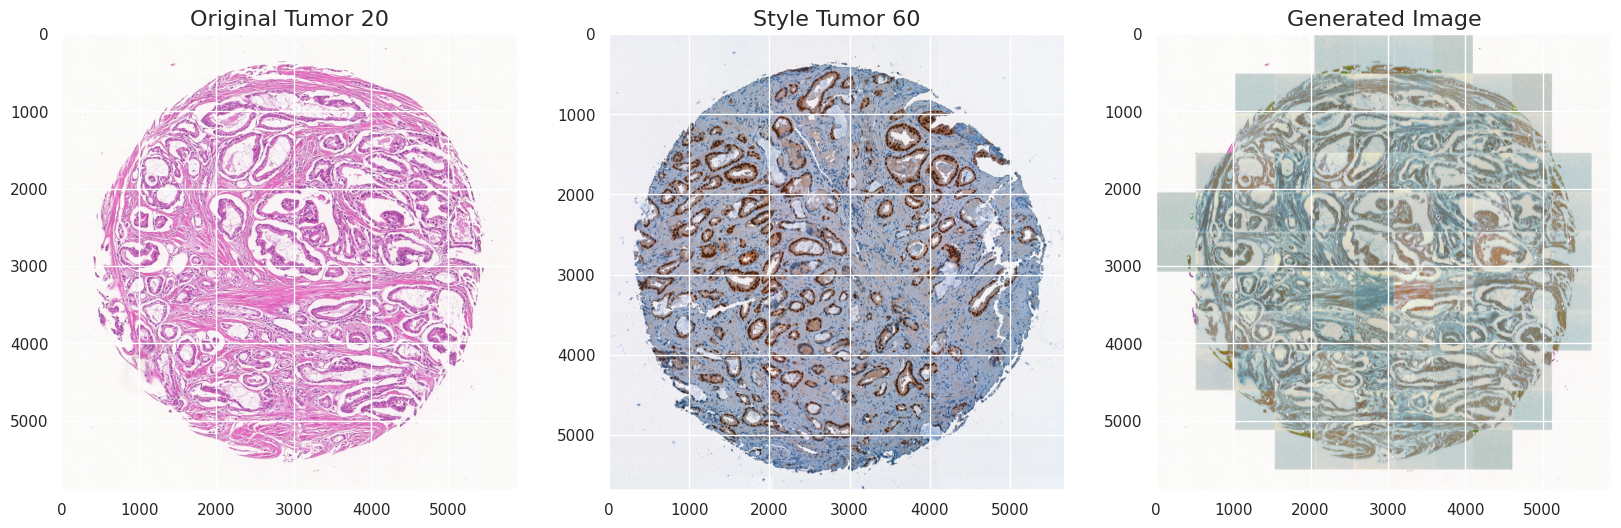

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(20, 15))  # 1x5 grid

# Plot original source image
axes[0].imshow(np.array(Image.open(tree_src.antibodies[idx_src])), cmap='viridis')
axes[0].set_title(f'Original Tumor {idx_src}', fontsize=16)

# Plot original destination image
axes[1].imshow(np.array(Image.open(tree_dst.antibodies[idx_dst])), cmap='viridis')
axes[1].set_title(f'Style Tumor {idx_dst}', fontsize=16)

# Plot decoded image
gen = []
with torch.no_grad():
    for i in range(len(patches_src)):
        # Assign idx_src and idx_dst to the patches
        src = patches_src[i]
        dst = patches_dst[torch.randint(0, len(patches_dst), (1,)).item()]

        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        out = pipeline(src_tensor, dst_tensor, timesteps)
        gen.append(out.to(torch.uint8)[0].permute(1,2,0).detach().cpu().numpy())

generated = PatchesUtilities.replace_patches_in_image(
    original_image=np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask=PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src]))),
    generated_patches=gen
)
axes[2].imshow(generated, cmap='viridis')
axes[2].set_title(f'Generated Image', fontsize=16)

In [24]:
pipeline.eval()
# for m in pipeline.modules():
#     if isinstance(m, nn.BatchNorm2d):
#         m.train()


OSGenPipeline(
  (encoder): VanillaEncoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (fc_mu): Linear(in_features=32, out_features=64, bias=True)
    (fc_var): Linear(in_features=32, out_features=64, bias=True)
    (noise_predictor): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (decoder_input): Linear(in_features=64, out_features=8192, bias=True)
    (decoder): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=

In [25]:
idx_src = 20 # torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = PatchesUtilities.get_image_patches_full(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
)

idx_dst = 60 # torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = PatchesUtilities.get_image_patches_full(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

idx_src:  20
idx_dst:  60


Text(0.5, 1.0, 'Generated Image')

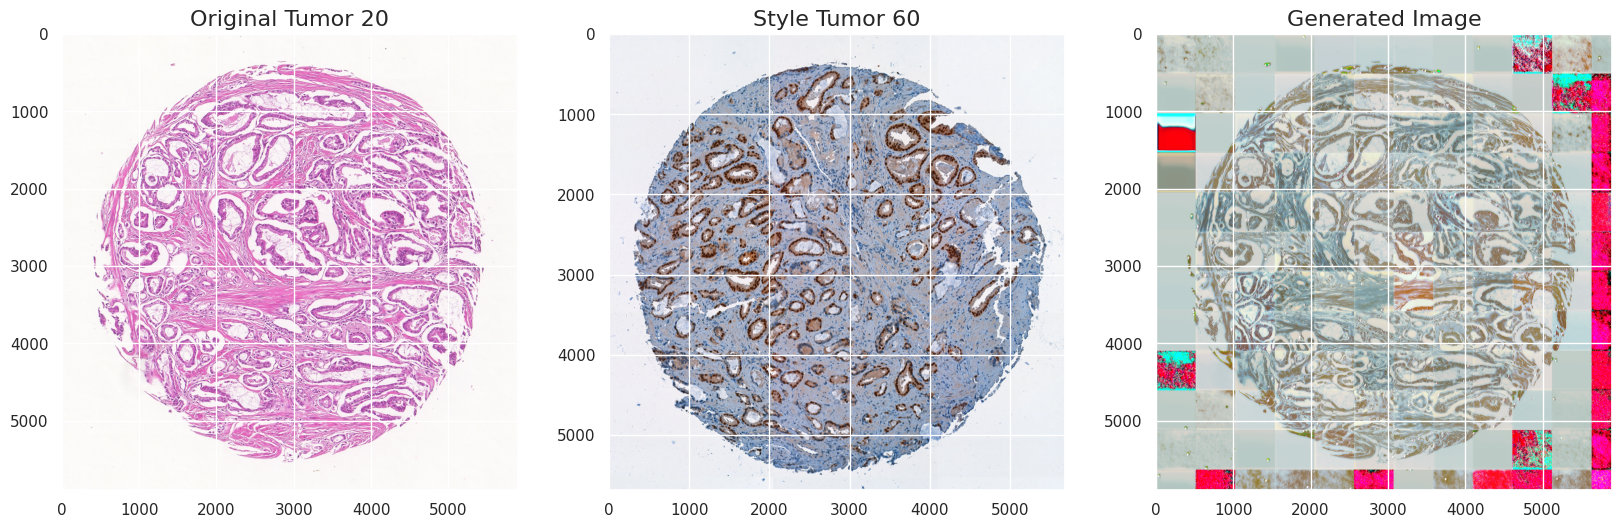

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(20, 15))  # 1x5 grid

# Plot original source image
axes[0].imshow(np.array(Image.open(tree_src.antibodies[idx_src])), cmap='viridis')
axes[0].set_title(f'Original Tumor {idx_src}', fontsize=16)

# Plot original destination image
axes[1].imshow(np.array(Image.open(tree_dst.antibodies[idx_dst])), cmap='viridis')
axes[1].set_title(f'Style Tumor {idx_dst}', fontsize=16)

# Plot decoded image
gen = []
with torch.no_grad():
    for i in range(len(patches_src)):
        # Assign idx_src and idx_dst to the patches
        src = patches_src[i]
        dst = patches_dst[torch.randint(0, len(patches_dst), (1,)).item()]

        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        out = pipeline(src_tensor, dst_tensor, timesteps)
        gen.append(out.to(torch.uint8)[0].permute(1,2,0).detach().cpu().numpy())

generated = PatchesUtilities.replace_patches_in_image_full(
    original_image=np.array(Image.open(tree_src.antibodies[idx_src])),
    generated_patches=gen
)
axes[2].imshow(generated, cmap='viridis')
axes[2].set_title(f'Generated Image', fontsize=16)